!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

In [1]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Input, Add,
                                    BatchNormalization, LeakyReLU, Concatenate, GlobalAveragePooling2D,Conv2D, AveragePooling2D)
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
import tensorflow.keras.applications as tfa
#import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


In [2]:
!pip install python-gdcm
!pip install GDCM
!pip install pylibjpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 7.3 MB/s eta 0:00:0000:0100:01


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-08-04 20:22:46.218754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 20:22:46.296251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 20:22:46.412150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 20:22:46.413072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [4]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
def get_tab(df):
    ''' 
    This function gives an array wrt each patient containing
    feature like age, gender and smoking status
    '''
    vector = [(df.Age.values[0]-30)/30]
    
    if df.Sex.values[0].lower() == 'male':
        vector.append(0)
    else:
        vector.append(1)
        
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])

    #print(vector)

    return np.array(vector)

In [6]:
print(52)

52


In [7]:
A = {} #Stores slope value for each of the patient
TAB = {} #Stores training data wrt each patient
P = [] #Stores all unique patient id's

for i,p in enumerate(train.Patient.unique()):
    sub = train.loc[train.Patient == p, :]
    fvc = sub.FVC.values
    week = sub.Weeks.values
    c = np.vstack([week, np.ones(len(week))]).T
    a, b = np.linalg.lstsq(c,fvc)[0]
    
    A[p] = a # Contains slope
    TAB[p] = get_tab(sub) #Contains gender and smoking feature
    P.append(p) #contains unique id

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


In [8]:
#redundant patients :

bad_id = []#'ID00104637202208063407045','ID00105637202208831864134','ID00168637202237852027833','ID00202637202249376026949','ID00267637202270790561585']
len(bad_id)

0

In [9]:
#removing redundant patient's data :

for i in bad_id:
    del TAB[i]

In [10]:
for i in bad_id:
    del A[i]

In [11]:
Patients = [y for y in P if y not in bad_id]
len(Patients)

176

In [12]:
# image_scores = {'ID00007637202177411956430': 0.004568628265058285,            OLD UNMODIFIED IMAGE SCORES
#  'ID00009637202177434476278': 0.02097333829010457,
#  'ID00010637202177584971671': 0.027226343640849544,
#  'ID00011637202177653955184': 0.3897294512044158,
#  'ID00012637202177665765362': 0.006843852496355684,
#  'ID00014637202177757139317': 0.0024756137083945333,
#  'ID00015637202177877247924': 0.005844654393856008,
#  'ID00019637202178323708467': 0.007739772820794695,
#  'ID00020637202178344345685': 0.013271960746951228,
#  'ID00023637202179104603099': 0.26120183203417446,
#  'ID00025637202179541264076': 0.006623690480261732,
#  'ID00026637202179561894768': 0.01248529630129065,
#  'ID00027637202179689871102': 0.07706213407409235,
#  'ID00030637202181211009029': 0.004641438458593173,
#  'ID00032637202181710233084': 0.005266746482460305,
#  'ID00035637202182204917484': 0.004897731636208489,
#  'ID00038637202182690843176': 0.06014738375832116,
#  'ID00042637202184406822975': 0.005273851414484803,
#  'ID00047637202184938901501': 0.24053306575402092,
#  'ID00048637202185016727717': 0.0023672315809461805,
#  'ID00051637202185848464638': 0.0786026234563366,
#  'ID00052637202186188008618': 0.005137893292763942,
#  'ID00060637202187965290703': 0.0056904438092290795,
#  'ID00061637202188184085559': 0.006089902018167598,
#  'ID00062637202188654068490': 0.005378984651711925,
#  'ID00067637202189903532242': 0.0047838344471126315,
#  'ID00068637202190879923934': 0.008847237716508942,
#  'ID00072637202198161894406': 0.02703401736326523,
#  'ID00073637202198167792918': 0.18003782975593022,
#  'ID00075637202198610425520': 0.0041287890625,
#  'ID00076637202199015035026': 0.035696029350413494,
#  'ID00077637202199102000916': 0.0063768364779874225,
#  'ID00078637202199415319443': 0.0071422495537706325,
#  'ID00082637202201836229724': 0.004251604948199375,
#  'ID00086637202203494931510': 0.034669413567330255,
#  'ID00089637202204675567570': 0.33201205357142854,
#  'ID00090637202204766623410': 0.21835072962648538,
#  'ID00093637202205278167493': 0.004612799508829754,
#  'ID00094637202205333947361': 0.08305895061728397,
#  'ID00099637202206203080121': 0.005610840651648212,
#  'ID00102637202206574119190': 0.005019246536318285,
#  'ID00108637202209619669361': 0.005573471257716052,
#  'ID00109637202210454292264': 0.004736937611430821,
#  'ID00110637202210673668310': 0.11886417657512448,
#  'ID00111637202210956877205': 0.007643050730117852,
#  'ID00115637202211874187958': 0.006083383047387676,
#  'ID00117637202212360228007': 0.00746855409723406,
#  'ID00119637202215426335765': 0.011684624237717612,
#  'ID00122637202216437668965': 0.005201723033548672,
#  'ID00123637202217151272140': 0.006611350492700459,
#  'ID00124637202217596410344': 0.019377665378744635,
#  'ID00125637202218590429387': 0.0032189454666041563,
#  'ID00126637202218610655908': 0.14502461787184012,
#  'ID00127637202219096738943': 0.00699430251124982,
#  'ID00128637202219474716089': 0.010832722981770834,
#  'ID00129637202219868188000': 0.11502524030672545,
#  'ID00130637202220059448013': 0.0032562806476995696,
#  'ID00131637202220424084844': 0.007375533325146497,
#  'ID00132637202222178761324': 0.3395414819916242,
#  'ID00133637202223847701934': 0.009665893343471888,
#  'ID00134637202223873059688': 0.005048046380596143,
#  'ID00135637202224630271439': 0.008047862151885958,
#  'ID00136637202224951350618': 0.006668723659069512,
#  'ID00138637202231603868088': 0.19622375049330665,
#  'ID00139637202231703564336': 0.4265920739619372,
#  'ID00140637202231728595149': 0.0829792940893464,
#  'ID00149637202232704462834': 0.13574800290486574,
#  'ID00161637202235731948764': 0.32336238424217834,
#  'ID00165637202237320314458': 0.004078506185686207,
#  'ID00167637202237397919352': 0.0232659297280372,
#  'ID00169637202238024117706': 0.0035424671723844345,
#  'ID00170637202238079193844': 0.4329705449011236,
#  'ID00172637202238316925179': 0.004836588831626052,
#  'ID00173637202238329754031': 0.005317288707491011,
#  'ID00180637202240177410333': 0.006645180437768173,
#  'ID00183637202241995351650': 0.005996730898614728,
#  'ID00184637202242062969203': 0.18219074436249685,
#  'ID00186637202242472088675': 0.1749656167508959,
#  'ID00190637202244450116191': 0.19097607305171554,
#  'ID00192637202245493238298': 0.007684714702207416,
#  'ID00196637202246668775836': 0.002909273928336527,
#  'ID00197637202246865691526': 0.0750936050398596,
#  'ID00199637202248141386743': 0.006896885847968938,
#  'ID00207637202252526380974': 0.009250460553001626,
#  'ID00210637202257228694086': 0.009040231443924594,
#  'ID00213637202257692916109': 0.09077244910545947,
#  'ID00214637202257820847190': 0.006892185746352413,
#  'ID00216637202257988213445': 0.00429783950617284,
#  'ID00218637202258156844710': 0.22005727022088162,
#  'ID00219637202258203123958': 0.07667148853005253,
#  'ID00221637202258717315571': 0.21215867141450392,
#  'ID00222637202259066229764': 0.08944963582570048,
#  'ID00224637202259281193413': 0.056896436196619854,
#  'ID00225637202259339837603': 0.05835038758607481,
#  'ID00228637202259965313869': 0.28156187521059145,
#  'ID00229637202260254240583': 0.008108088235294117,
#  'ID00232637202260377586117': 0.0057020286323484605,
#  'ID00233637202260580149633': 0.0022683423629939465,
#  'ID00234637202261078001846': 0.00488973433800765,
#  'ID00235637202261451839085': 0.005001993523497457,
#  'ID00240637202264138860065': 0.003385577201016516,
#  'ID00241637202264294508775': 0.005419762845849805,
#  'ID00242637202264759739921': 0.006792929292929294,
#  'ID00248637202266698862378': 0.006305169753086421,
#  'ID00249637202266730854017': 0.004509458072182217,
#  'ID00251637202267455595113': 0.007633333333333337,
#  'ID00255637202267923028520': 0.005246673288768378,
#  'ID00264637202270643353440': 0.10604636994949501,
#  'ID00273637202271319294586': 0.04546863566353203,
#  'ID00275637202271440119890': 0.008285338761055487,
#  'ID00276637202271694539978': 0.0066655694535878865,
#  'ID00279637202272164826258': 0.006518830091102851,
#  'ID00283637202278714365037': 0.004573086671120587,
#  'ID00285637202278913507108': 0.29178232903977885,
#  'ID00288637202279148973731': 0.006508784425451093,
#  'ID00290637202279304677843': 0.0057302469135802475,
#  'ID00291637202279398396106': 0.030330124782206876,
#  'ID00294637202279614924243': 0.004939146567717996,
#  'ID00296637202279895784347': 0.010377504794544962,
#  'ID00298637202280361773446': 0.010786576704545452,
#  'ID00299637202280383305867': 0.0029912531423951783,
#  'ID00305637202281772703145': 0.3489909049501428,
#  'ID00307637202282126172865': 0.005716953189715694,
#  'ID00309637202282195513787': 0.2893255694269206,
#  'ID00312637202282607344793': 0.007230380893166086,
#  'ID00317637202283194142136': 0.03133787310907144,
#  'ID00319637202283897208687': 0.1111367060582748,
#  'ID00322637202284842245491': 0.14159115943573894,
#  'ID00323637202285211956970': 0.23105156945873095,
#  'ID00329637202285906759848': 0.07548884881352415,
#  'ID00331637202286306023714': 0.10720906640712728,
#  'ID00335637202286784464927': 0.009280912883460972,
#  'ID00336637202286801879145': 0.036125943032849946,
#  'ID00337637202286839091062': 0.0067312977580738205,
#  'ID00339637202287377736231': 0.01036761463844797,
#  'ID00340637202287399835821': 0.005741473692501575,
#  'ID00341637202287410878488': 0.006909833471777223,
#  'ID00342637202287526592911': 0.004662990196078432,
#  'ID00343637202287577133798': 0.00452538422776518,
#  'ID00344637202287684217717': 0.011368309723560411,
#  'ID00351637202289476567312': 0.007130712325498152,
#  'ID00355637202295106567614': 0.012066242818323674,
#  'ID00358637202295388077032': 0.010178009577660158,
#  'ID00360637202295712204040': 0.06940469440075671,
#  'ID00364637202296074419422': 0.2446096544351377,
#  'ID00365637202296085035729': 0.023813939819218376,
#  'ID00367637202296290303449': 0.00465735179826408,
#  'ID00368637202296470751086': 0.02017153445099505,
#  'ID00370637202296737666151': 0.16448315517823286,
#  'ID00371637202296828615743': 0.08692771408013772,
#  'ID00376637202297677828573': 0.009281901872657677,
#  'ID00378637202298597306391': 0.004424432837060677,
#  'ID00381637202299644114027': 0.002778246627200623,
#  'ID00383637202300493233675': 0.15847826760912698,
#  'ID00388637202301028491611': 0.006343371212121213,
#  'ID00392637202302319160044': 0.0047023323615160385,
#  'ID00393637202302431697467': 0.0058351139607954105,
#  'ID00398637202303897337979': 0.007244270451683946,
#  'ID00400637202305055099402': 0.18727654548211875,
#  'ID00401637202305320178010': 0.005280349794238683,
#  'ID00405637202308359492977': 0.03858955320247932,
#  'ID00407637202308788732304': 0.00437361111111111,
#  'ID00408637202308839708961': 0.055230549728918665,
#  'ID00411637202309374271828': 0.02319532374100721,
#  'ID00414637202310318891556': 0.007883297959183673,
#  'ID00417637202310901214011': 0.0043345123359016385,
#  'ID00419637202311204720264': 0.002493499531827058,
#  'ID00421637202311550012437': 0.036695882287117405,
#  'ID00422637202311677017371': 0.015953544374824668,
#  'ID00423637202312137826377': 0.12067498922627552,
#  'ID00426637202313170790466': 0.03336206661894431}

image_scores = {'ID00007637202177411956430': 0.006109935816988777,          #MIDDLE 50% SLICES WITH WINDOW WIDTH AS 1200HU
 'ID00009637202177434476278': 0.00998286270143417,
 'ID00010637202177584971671': 0.042589622369083306,
 'ID00011637202177653955184': 0.707747575444149,
 'ID00012637202177665765362': 0.009845312500000002,
 'ID00014637202177757139317': 0.0028147868271768796,
 'ID00015637202177877247924': 0.00817012770991693,
 'ID00019637202178323708467': 0.009739062644774385,
 'ID00020637202178344345685': 0.014441626764112907,
 'ID00023637202179104603099': 0.40188743559254847,
 'ID00025637202179541264076': 0.006510265266805741,
 'ID00026637202179561894768': 0.01271704879575747,
 'ID00027637202179689871102': 0.007372614881372087,
 'ID00030637202181211009029': 0.006900174656942289,
 'ID00032637202181710233084': 0.0076503092832608975,
 'ID00035637202182204917484': 0.006443480725623585,
 'ID00038637202182690843176': 0.11633738356547439,
 'ID00042637202184406822975': 0.006043577071176213,
 'ID00047637202184938901501': 0.4274295681075558,
 'ID00048637202185016727717': 0.05890608422550154,
 'ID00051637202185848464638': 0.14952760598177803,
 'ID00052637202186188008618': 0.00790396180975944,
 'ID00060637202187965290703': 0.008602362936310453,
 'ID00061637202188184085559': 0.005520668524269641,
 'ID00062637202188654068490': 0.008149772305616462,
 'ID00067637202189903532242': 0.004944423792969578,
 'ID00068637202190879923934': 0.023914444444444453,
 'ID00072637202198161894406': 0.011855975229378686,
 'ID00073637202198167792918': 0.005024087187378434,
 'ID00075637202198610425520': 0.35642030095220584,
 'ID00076637202199015035026': 0.004243828124999997,
 'ID00077637202199102000916': 0.03351054882737411,
 'ID00078637202199415319443': 0.0064087021943573675,
 'ID00082637202201836229724': 0.007622308568489122,
 'ID00086637202203494931510': 0.00458651642475172,
 'ID00089637202204675567570': 0.06595396956633676,
 'ID00090637202204766623410': 0.42289788194444444,
 'ID00093637202205278167493': 0.37143868515887335,
 'ID00094637202205333947361': 0.00519525632947183,
 'ID00099637202206203080121': 0.08077131089570246,
 'ID00102637202206574119190': 0.007505654912903767,
 'ID00104637202208063407045': 0.006732179930795851,
 'ID00105637202208831864134': 0.0043123801969727005,
 'ID00108637202209619669361': 0.006663483796296293,
 'ID00109637202210454292264': 0.006969577150457032,
 'ID00110637202210673668310': 0.2301235718492867,
 'ID00111637202210956877205': 0.012561319629741729,
 'ID00115637202211874187958': 0.008332794265274194,
 'ID00117637202212360228007': 0.008467362277903588,
 'ID00119637202215426335765': 0.004889500790485622,
 'ID00122637202216437668965': 0.005699030677157319,
 'ID00123637202217151272140': 0.010900114531093474,
 'ID00124637202217596410344': 0.009901914434299193,
 'ID00125637202218590429387': 0.005299788394321333,
 'ID00126637202218610655908': 0.09331018518518519,
 'ID00127637202219096738943': 0.00981218665207633,
 'ID00128637202219474716089': 0.010482991536458333,
 'ID00129637202219868188000': 0.0059574156459969605,
 'ID00130637202220059448013': 0.004364584452635556,
 'ID00131637202220424084844': 0.010242676717582487,
 'ID00132637202222178761324': 0.47825375981862683,
 'ID00133637202223847701934': 0.011774427572722124,
 'ID00134637202223873059688': 0.007953443157833499,
 'ID00135637202224630271439': 0.01069332572176468,
 'ID00136637202224951350618': 0.008738746537396121,
 'ID00138637202231603868088': 0.33805997930485465,
 'ID00139637202231703564336': 0.663998161764706,
 'ID00140637202231728595149': 0.15678337439355908,
 'ID00149637202232704462834': 0.23986125541125528,
 'ID00161637202235731948764': 0.6434295906508264,
 'ID00165637202237320314458': 0.00617033038501561,
 'ID00167637202237397919352': 0.041563138378186364,
 'ID00168637202237852027833': 0.13233141324001166,
 'ID00169637202238024117706': 0.004797864154285078,
 'ID00170637202238079193844': 0.4114739657677816,
 'ID00172637202238316925179': 0.007097497776230808,
 'ID00173637202238329754031': 0.007130472379779854,
 'ID00180637202240177410333': 0.008769825566909702,
 'ID00183637202241995351650': 0.007683250815118947,
 'ID00184637202242062969203': 0.30208669649379105,
 'ID00186637202242472088675': 0.22429520527302033,
 'ID00190637202244450116191': 0.3878935922798754,
 'ID00192637202245493238298': 0.005167625315708939,
 'ID00196637202246668775836': 0.003987913854066219,
 'ID00197637202246865691526': 0.07550584611076101,
 'ID00199637202248141386743': 0.007863464161812371,
 'ID00202637202249376026949': 0.010957940000671886,
 'ID00207637202252526380974': 0.008658660509058946,
 'ID00210637202257228694086': 0.011036528612202366,
 'ID00213637202257692916109': 0.008060708432873579,
 'ID00214637202257820847190': 0.006796553497942388,
 'ID00216637202257988213445': 0.005939253647586981,
 'ID00218637202258156844710': 0.4509800225031122,
 'ID00219637202258203123958': 0.14891558929308835,
 'ID00221637202258717315571': 0.3801395540193602,
 'ID00222637202259066229764': 0.17064868723179194,
 'ID00224637202259281193413': 0.07238675122470797,
 'ID00225637202259339837603': 0.11203574426290808,
 'ID00228637202259965313869': 0.49307446956949963,
 'ID00229637202260254240583': 0.010952777777777778,
 'ID00232637202260377586117': 0.006221061224489796,
 'ID00233637202260580149633': 0.0033098183131813784,
 'ID00234637202261078001846': 0.005584829152249138,
 'ID00235637202261451839085': 0.0077137931509860935,
 'ID00240637202264138860065': 0.003987872826288803,
 'ID00241637202264294508775': 0.0065561515748031466,
 'ID00242637202264759739921': 0.006572788065843622,
 'ID00248637202266698862378': 0.006709104938271605,
 'ID00249637202266730854017': 0.004151961272534283,
 'ID00251637202267455595113': 0.011457142857142858,
 'ID00255637202267923028520': 0.006601267819270317,
 'ID00264637202270643353440': 0.004213366336633662,
 'ID00267637202270790561585': 0.005892755681818182,
 'ID00273637202271319294586': 0.007826419089450072,
 'ID00275637202271440119890': 0.011023057320566545,
 'ID00276637202271694539978': 0.00974604893732641,
 'ID00279637202272164826258': 0.007845317599963372,
 'ID00283637202278714365037': 0.006673579260112524,
 'ID00285637202278913507108': 0.4130567551277954,
 'ID00288637202279148973731': 0.008405533509700178,
 'ID00290637202279304677843': 0.007963117283950617,
 'ID00291637202279398396106': 0.008959146225330067,
 'ID00294637202279614924243': 0.007340476190476192,
 'ID00296637202279895784347': 0.01243691958553555,
 'ID00298637202280361773446': 0.01182961856617647,
 'ID00299637202280383305867': 0.004565683421241534,
 'ID00305637202281772703145': 0.6455751886731256,
 'ID00307637202282126172865': 0.007365465034644853,
 'ID00309637202282195513787': 0.49479551265024213,
 'ID00312637202282607344793': 0.008503325043252593,
 'ID00317637202283194142136': 0.03583879015219448,
 'ID00319637202283897208687': 0.2075489343396085,
 'ID00322637202284842245491': 0.2753723623716283,
 'ID00323637202285211956970': 0.4397900661655931,
 'ID00329637202285906759848': 0.09546303047601748,
 'ID00331637202286306023714': 0.15512957428196528,
 'ID00335637202286784464927': 0.010978150386790916,
 'ID00336637202286801879145': 0.06715724733742752,
 'ID00337637202286839091062': 0.015412529135428673,
 'ID00339637202287377736231': 0.013029376102292767,
 'ID00340637202287399835821': 0.008901671786389414,
 'ID00341637202287410878488': 0.01049305802776789,
 'ID00342637202287526592911': 0.0073935997400909675,
 'ID00343637202287577133798': 0.005314577397910731,
 'ID00344637202287684217717': 0.013119888132141832,
 'ID00351637202289476567312': 0.01014936562860438,
 'ID00355637202295106567614': 0.015452573168950916,
 'ID00358637202295388077032': 0.01757170912119418,
 'ID00360637202295712204040': 0.08782369896804355,
 'ID00364637202296074419422': 0.471549898998819,
 'ID00365637202296085035729': 0.008679829741303635,
 'ID00367637202296290303449': 0.006574780285241729,
 'ID00368637202296470751086': 0.008677464077019414,
 'ID00370637202296737666151': 0.3190552143548454,
 'ID00371637202296828615743': 0.08349501087064878,
 'ID00376637202297677828573': 0.011428552891380287,
 'ID00378637202298597306391': 0.0068357734850724656,
 'ID00381637202299644114027': 0.00357130857639838,
 'ID00383637202300493233675': 0.3149635505243764,
 'ID00388637202301028491611': 0.008977703488372091,
 'ID00392637202302319160044': 0.006272827988338195,
 'ID00393637202302431697467': 0.008733116863319009,
 'ID00398637202303897337979': 0.009678397143423926,
 'ID00400637202305055099402': 0.35828732447180633,
 'ID00401637202305320178010': 0.007172839506172838,
 'ID00405637202308359492977': 0.006616009168388431,
 'ID00407637202308788732304': 0.005330133928571427,
 'ID00408637202308839708961': 0.11557239485327772,
 'ID00411637202309374271828': 0.007764910714285711,
 'ID00414637202310318891556': 0.010664852607709751,
 'ID00417637202310901214011': 0.005666355376750285,
 'ID00419637202311204720264': 0.0025915818598745426,
 'ID00421637202311550012437': 0.06771043179607117,
 'ID00422637202311677017371': 0.008395445618629012,
 'ID00423637202312137826377': 0.23660580500172554,
 'ID00426637202313170790466': 0.009756720504837101}

# image_scores = {'ID00007637202177411956430': 0.007241654415719461,        # MIDDLE 50% SLICES WITH WINDOW WIDTH AS 1500HU
#  'ID00009637202177434476278': 0.008555907582660772,
#  'ID00010637202177584971671': 0.13478470004867865,
#  'ID00011637202177653955184': 0.648467243238485,
#  'ID00012637202177665765362': 0.06196713169642856,
#  'ID00014637202177757139317': 0.0044623427828536415,
#  'ID00015637202177877247924': 0.009279646709835358,
#  'ID00019637202178323708467': 0.008547958860911154,
#  'ID00020637202178344345685': 0.038945470010080654,
#  'ID00023637202179104603099': 0.4019770114942529,
#  'ID00025637202179541264076': 0.004546128153391926,
#  'ID00026637202179561894768': 0.0156382902542488,
#  'ID00027637202179689871102': 0.007706919620235424,
#  'ID00030637202181211009029': 0.00659145066736839,
#  'ID00032637202181710233084': 0.007761158163656198,
#  'ID00035637202182204917484': 0.006698696145124715,
#  'ID00038637202182690843176': 0.15745167807110147,
#  'ID00042637202184406822975': 0.005979987892501289,
#  'ID00047637202184938901501': 0.3808027757295835,
#  'ID00048637202185016727717': 0.005939624927662038,
#  'ID00051637202185848464638': 0.16558304580716873,
#  'ID00052637202186188008618': 0.007103259725219775,
#  'ID00060637202187965290703': 0.008854405322825856,
#  'ID00061637202188184085559': 0.005638083130289195,
#  'ID00062637202188654068490': 0.00905464665204925,
#  'ID00067637202189903532242': 0.005650798789592214,
#  'ID00068637202190879923934': 0.045956354166666664,
#  'ID00072637202198161894406': 0.00958179339095943,
#  'ID00073637202198167792918': 0.005023080049794369,
#  'ID00075637202198610425520': 0.43973617167762435,
#  'ID00076637202199015035026': 0.004681249999999999,
#  'ID00077637202199102000916': 0.08060529603998463,
#  'ID00078637202199415319443': 0.007010520376175548,
#  'ID00082637202201836229724': 0.008736772486772485,
#  'ID00086637202203494931510': 0.005947765469824293,
#  'ID00089637202204675567570': 0.12017690403200107,
#  'ID00090637202204766623410': 0.33490256944444435,
#  'ID00093637202205278167493': 0.37120864954604843,
#  'ID00094637202205333947361': 0.00486121209183591,
#  'ID00099637202206203080121': 0.08066582251767437,
#  'ID00102637202206574119190': 0.01239060121765601,
#  'ID00104637202208063407045': 0.007175086505190314,
#  'ID00105637202208831864134': 0.004439641306982176,
#  'ID00108637202209619669361': 0.005551697530864196,
#  'ID00109637202210454292264': 0.005685832013859236,
#  'ID00110637202210673668310': 0.2742863243893447,
#  'ID00111637202210956877205': 0.01902087466888076,
#  'ID00115637202211874187958': 0.008629281697800842,
#  'ID00117637202212360228007': 0.008168561943490717,
#  'ID00119637202215426335765': 0.005864949530107901,
#  'ID00122637202216437668965': 0.005857224927065515,
#  'ID00123637202217151272140': 0.03329125537937256,
#  'ID00124637202217596410344': 0.00908518976310229,
#  'ID00125637202218590429387': 0.005333448269492453,
#  'ID00126637202218610655908': 0.3661321548821549,
#  'ID00127637202219096738943': 0.010522976986723536,
#  'ID00128637202219474716089': 0.01335367838541667,
#  'ID00129637202219868188000': 0.004711950139532937,
#  'ID00130637202220059448013': 0.00632904285926432,
#  'ID00131637202220424084844': 0.007945787935158117,
#  'ID00132637202222178761324': 0.47825573953014716,
#  'ID00133637202223847701934': 0.01146227318820641,
#  'ID00134637202223873059688': 0.008750277973657223,
#  'ID00135637202224630271439': 0.00961078632549121,
#  'ID00136637202224951350618': 0.008732504738300048,
#  'ID00138637202231603868088': 0.3168021084365943,
#  'ID00139637202231703564336': 0.3028709991349481,
#  'ID00140637202231728595149': 0.07818639030317046,
#  'ID00149637202232704462834': 0.16063405483405485,
#  'ID00161637202235731948764': 0.7148668093270365,
#  'ID00165637202237320314458': 0.005887602613018847,
#  'ID00167637202237397919352': 0.06901412203570481,
#  'ID00168637202237852027833': 0.2788925144356956,
#  'ID00169637202238024117706': 0.007032932159269852,
#  'ID00170637202238079193844': 0.4670209482658847,
#  'ID00172637202238316925179': 0.005763623003442008,
#  'ID00173637202238329754031': 0.007972819475589551,
#  'ID00180637202240177410333': 0.008342644248053113,
#  'ID00183637202241995351650': 0.005000570247822996,
#  'ID00184637202242062969203': 0.28306181519357204,
#  'ID00186637202242472088675': 0.04818308224752739,
#  'ID00190637202244450116191': 0.2381968230637735,
#  'ID00192637202245493238298': 0.004235661744372547,
#  'ID00196637202246668775836': 0.004137939380187947,
#  'ID00197637202246865691526': 0.20253388913124262,
#  'ID00199637202248141386743': 0.007555525156838376,
#  'ID00202637202249376026949': 0.01024465011590016,
#  'ID00207637202252526380974': 0.007290997667658191,
#  'ID00210637202257228694086': 0.010813276200519346,
#  'ID00213637202257692916109': 0.010325669678257396,
#  'ID00214637202257820847190': 0.005709876543209876,
#  'ID00216637202257988213445': 0.004978254769921436,
#  'ID00218637202258156844710': 0.507777338887293,
#  'ID00219637202258203123958': 0.058792539346893484,
#  'ID00221637202258717315571': 0.42852272498248134,
#  'ID00222637202259066229764': 0.2039504877552366,
#  'ID00224637202259281193413': 0.21494824115880282,
#  'ID00225637202259339837603': 0.1568701213472567,
#  'ID00228637202259965313869': 0.5104554192145112,
#  'ID00229637202260254240583': 0.008590972222222222,
#  'ID00232637202260377586117': 0.006599043731778427,
#  'ID00233637202260580149633': 0.004149791571123807,
#  'ID00234637202261078001846': 0.0054001946366781985,
#  'ID00235637202261451839085': 0.008143062792180886,
#  'ID00240637202264138860065': 0.0052736526376939525,
#  'ID00241637202264294508775': 0.006084399606299216,
#  'ID00242637202264759739921': 0.005545267489711935,
#  'ID00248637202266698862378': 0.007097993827160495,
#  'ID00249637202266730854017': 0.004649389833947515,
#  'ID00251637202267455595113': 0.0840095238095238,
#  'ID00255637202267923028520': 0.007143228677279927,
#  'ID00264637202270643353440': 0.02054576113861385,
#  'ID00267637202270790561585': 0.004919921875000001,
#  'ID00273637202271319294586': 0.009453634697225039,
#  'ID00275637202271440119890': 0.010279179480824305,
#  'ID00276637202271694539978': 0.00917244671537254,
#  'ID00279637202272164826258': 0.008813717858988364,
#  'ID00283637202278714365037': 0.00853090122424898,
#  'ID00285637202278913507108': 0.00286961651160338,
#  'ID00288637202279148973731': 0.008431988536155203,
#  'ID00290637202279304677843': 0.00547829218106996,
#  'ID00291637202279398396106': 0.012285748531703222,
#  'ID00294637202279614924243': 0.00954387755102041,
#  'ID00296637202279895784347': 0.01280139396079134,
#  'ID00298637202280361773446': 0.013976332720588234,
#  'ID00299637202280383305867': 0.005299362535501392,
#  'ID00305637202281772703145': 0.20311924828053862,
#  'ID00307637202282126172865': 0.00810007834518686,
#  'ID00309637202282195513787': 0.39624294441862007,
#  'ID00312637202282607344793': 0.008773383434256052,
#  'ID00317637202283194142136': 0.04781667717702653,
#  'ID00319637202283897208687': 0.10841679993266558,
#  'ID00322637202284842245491': 0.3642516754681202,
#  'ID00323637202285211956970': 0.2942166902387418,
#  'ID00329637202285906759848': 0.11815856870402322,
#  'ID00331637202286306023714': 0.17701600087476296,
#  'ID00335637202286784464927': 0.010345299151930852,
#  'ID00336637202286801879145': 0.12532299124773952,
#  'ID00337637202286839091062': 0.07132690852076128,
#  'ID00339637202287377736231': 0.012052744708994709,
#  'ID00340637202287399835821': 0.008802907904064274,
#  'ID00341637202287410878488': 0.010078055984072359,
#  'ID00342637202287526592911': 0.007232781026640676,
#  'ID00343637202287577133798': 0.004068138651471985,
#  'ID00344637202287684217717': 0.010702861893921592,
#  'ID00351637202289476567312': 0.14203979238754322,
#  'ID00355637202295106567614': 0.016321769544749707,
#  'ID00358637202295388077032': 0.08726039526529,
#  'ID00360637202295712204040': 0.13589399657554266,
#  'ID00364637202296074419422': 0.4716214277041272,
#  'ID00365637202296085035729': 0.013673062149106338,
#  'ID00367637202296290303449': 0.008649446498415793,
#  'ID00368637202296470751086': 0.010839320965170833,
#  'ID00370637202296737666151': 0.3780968794845717,
#  'ID00371637202296828615743': 0.13255066220627462,
#  'ID00376637202297677828573': 0.01064054768816849,
#  'ID00378637202298597306391': 0.006184354990721041,
#  'ID00381637202299644114027': 0.003746336441809172,
#  'ID00383637202300493233675': 0.31540089994331066,
#  'ID00388637202301028491611': 0.014464360465116287,
#  'ID00392637202302319160044': 0.00866962099125365,
#  'ID00393637202302431697467': 0.009505742435862254,
#  'ID00398637202303897337979': 0.0103769886927197,
#  'ID00400637202305055099402': 0.14233919693802422,
#  'ID00401637202305320178010': 0.00712551440329218,
#  'ID00405637202308359492977': 0.00878099173553719,
#  'ID00407637202308788732304': 0.004558035714285715,
#  'ID00408637202308839708961': 0.1327216777300691,
#  'ID00411637202309374271828': 0.007129464285714284,
#  'ID00414637202310318891556': 0.012111888564949795,
#  'ID00417637202310901214011': 0.006937482501927186,
#  'ID00419637202311204720264': 0.0029153603848725805,
#  'ID00421637202311550012437': 0.06876652155540922,
#  'ID00422637202311677017371': 0.009044526793229217,
#  'ID00423637202312137826377': 0.22290097909471093,
#  'ID00426637202313170790466': 0.0096992032576263}



# image_scores = {'ID00007637202177411956430': 0.006028810642188675,        #Middle 50% slices with 1000HU as WW
#  'ID00009637202177434476278': 0.010854026008289365,
#  'ID00010637202177584971671': 0.015964043794295522,
#  'ID00011637202177653955184': 0.5914795942524206,
#  'ID00012637202177665765362': 0.01197751116071429,
#  'ID00014637202177757139317': 0.0033025967194385553,
#  'ID00015637202177877247924': 0.007115637842253895,
#  'ID00019637202178323708467': 0.012040116682162517,
#  'ID00020637202178344345685': 0.006124070690524194,
#  'ID00023637202179104603099': 0.13630757035275468,
#  'ID00025637202179541264076': 0.008697832951449446,
#  'ID00026637202179561894768': 0.011592499046971705,
#  'ID00027637202179689871102': 0.006498201659906716,
#  'ID00030637202181211009029': 0.00592874753515283,
#  'ID00032637202181710233084': 0.008134099939547876,
#  'ID00035637202182204917484': 0.007553117913832199,
#  'ID00038637202182690843176': 0.08625645435577137,
#  'ID00042637202184406822975': 0.007030536699614938,
#  'ID00047637202184938901501': 0.3048452500814078,
#  'ID00048637202185016727717': 0.05880774980709876,
#  'ID00051637202185848464638': 0.14139990735160937,
#  'ID00052637202186188008618': 0.008764508869821549,
#  'ID00060637202187965290703': 0.0092358255293105,
#  'ID00061637202188184085559': 0.006058552107916366,
#  'ID00062637202188654068490': 0.008233260246247261,
#  'ID00067637202189903532242': 0.005755957346948784,
#  'ID00068637202190879923934': 0.01853756944444444,
#  'ID00072637202198161894406': 0.013170143711090371,
#  'ID00073637202198167792918': 0.005262032766960184,
#  'ID00075637202198610425520': 0.2527375032567396,
#  'ID00076637202199015035026': 0.004648554687499999,
#  'ID00077637202199102000916': 0.012546196174548246,
#  'ID00078637202199415319443': 0.00651371786833856,
#  'ID00082637202201836229724': 0.006749706055261612,
#  'ID00086637202203494931510': 0.005517093200916729,
#  'ID00089637202204675567570': 0.06657321306853302,
#  'ID00090637202204766623410': 0.4170025,
#  'ID00093637202205278167493': 0.3189680535131665,
#  'ID00094637202205333947361': 0.008004338131937374,
#  'ID00099637202206203080121': 0.08077456109331448,
#  'ID00102637202206574119190': 0.005517768053441569,
#  'ID00104637202208063407045': 0.008068719723183392,
#  'ID00105637202208831864134': 0.004565712648996409,
#  'ID00108637202209619669361': 0.00763994984567901,
#  'ID00109637202210454292264': 0.008313766777817935,
#  'ID00110637202210673668310': 0.17073324666671055,
#  'ID00111637202210956877205': 0.006396500814245058,
#  'ID00115637202211874187958': 0.007891357421290074,
#  'ID00117637202212360228007': 0.008672311913052655,
#  'ID00119637202215426335765': 0.0034876546454933465,
#  'ID00122637202216437668965': 0.007514433931175769,
#  'ID00123637202217151272140': 0.004297880706659966,
#  'ID00124637202217596410344': 0.010755834154510403,
#  'ID00125637202218590429387': 0.005436480326418692,
#  'ID00126637202218610655908': 0.0042227833894500555,
#  'ID00127637202219096738943': 0.010394916086961374,
#  'ID00128637202219474716089': 0.008562418619791666,
#  'ID00129637202219868188000': 0.007796059600310713,
#  'ID00130637202220059448013': 0.003427570028577672,
#  'ID00131637202220424084844': 0.012332309028232643,
#  'ID00132637202222178761324': 0.5026244045770135,
#  'ID00133637202223847701934': 0.015257366216778392,
#  'ID00134637202223873059688': 0.006810910472563043,
#  'ID00135637202224630271439': 0.01378399444143477,
#  'ID00136637202224951350618': 0.008967597317393203,
#  'ID00138637202231603868088': 0.5462683896573095,
#  'ID00139637202231703564336': 0.5389712370242209,
#  'ID00140637202231728595149': 0.08900890739519557,
#  'ID00149637202232704462834': 0.16857857142857133,
#  'ID00161637202235731948764': 0.28679519166912637,
#  'ID00165637202237320314458': 0.006180266504798243,
#  'ID00167637202237397919352': 0.006244837463362645,
#  'ID00168637202237852027833': 0.046282620005832616,
#  'ID00169637202238024117706': 0.00444335536487736,
#  'ID00170637202238079193844': 0.3781781395608021,
#  'ID00172637202238316925179': 0.008131647136172024,
#  'ID00173637202238329754031': 0.006375459848451538,
#  'ID00180637202240177410333': 0.010521603046393355,
#  'ID00183637202241995351650': 0.008032527606703432,
#  'ID00184637202242062969203': 0.1774595507669831,
#  'ID00186637202242472088675': 0.32150834938564415,
#  'ID00190637202244450116191': 0.2908689764297184,
#  'ID00192637202245493238298': 0.005575327692052429,
#  'ID00196637202246668775836': 0.003759078790629078,
#  'ID00197637202246865691526': 0.025062284911056165,
#  'ID00199637202248141386743': 0.010719841622683529,
#  'ID00202637202249376026949': 0.013514966237780089,
#  'ID00207637202252526380974': 0.0104325289852623,
#  'ID00210637202257228694086': 0.012184455484840907,
#  'ID00213637202257692916109': 0.005864521212456859,
#  'ID00214637202257820847190': 0.006525848765432098,
#  'ID00216637202257988213445': 0.0062822671156004505,
#  'ID00218637202258156844710': 0.4134863066168726,
#  'ID00219637202258203123958': 0.20143488132362616,
#  'ID00221637202258717315571': 0.3453378671158462,
#  'ID00222637202259066229764': 0.07128937659634849,
#  'ID00224637202259281193413': 0.03742114290413404,
#  'ID00225637202259339837603': 0.042295460016979,
#  'ID00228637202259965313869': 0.44186829728731497,
#  'ID00229637202260254240583': 0.012638194444444447,
#  'ID00232637202260377586117': 0.006912513119533526,
#  'ID00233637202260580149633': 0.002848991276844398,
#  'ID00234637202261078001846': 0.006801200259515567,
#  'ID00235637202261451839085': 0.007789162487946347,
#  'ID00240637202264138860065': 0.004573201132014584,
#  'ID00241637202264294508775': 0.007287401574803153,
#  'ID00242637202264759739921': 0.0069952417695473244,
#  'ID00248637202266698862378': 0.006946759259259259,
#  'ID00249637202266730854017': 0.00530785208232832,
#  'ID00251637202267455595113': 0.012642063492063493,
#  'ID00255637202267923028520': 0.0061281007543826675,
#  'ID00264637202270643353440': 0.012922400990099014,
#  'ID00267637202270790561585': 0.0066876775568181866,
#  'ID00273637202271319294586': 0.007283411437540466,
#  'ID00275637202271440119890': 0.012674719376214758,
#  'ID00276637202271694539978': 0.011162129422775027,
#  'ID00279637202272164826258': 0.007725943707851205,
#  'ID00283637202278714365037': 0.005051063052685553,
#  'ID00285637202278913507108': 0.0600883100821947,
#  'ID00288637202279148973731': 0.008294753086419753,
#  'ID00290637202279304677843': 0.009647993827160497,
#  'ID00291637202279398396106': 0.007177499343480012,
#  'ID00294637202279614924243': 0.006687755102040817,
#  'ID00296637202279895784347': 0.012447019477861913,
#  'ID00298637202280361773446': 0.013079044117647062,
#  'ID00299637202280383305867': 0.0037975269966605296,
#  'ID00305637202281772703145': 0.5552119396350726,
#  'ID00307637202282126172865': 0.007970350925388928,
#  'ID00309637202282195513787': 0.4038055315758019,
#  'ID00312637202282607344793': 0.010576408412629757,
#  'ID00317637202283194142136': 0.03642870182695818,
#  'ID00319637202283897208687': 0.2069555499443556,
#  'ID00322637202284842245491': 0.17968726171349939,
#  'ID00323637202285211956970': 0.42433031242889635,
#  'ID00329637202285906759848': 0.07978037546868715,
#  'ID00331637202286306023714': 0.1337615541624144,
#  'ID00335637202286784464927': 0.014220967404039386,
#  'ID00336637202286801879145': 0.009323048538734814,
#  'ID00337637202286839091062': 0.004349251189446366,
#  'ID00339637202287377736231': 0.015485008818342154,
#  'ID00340637202287399835821': 0.00979423883506616,
#  'ID00341637202287410878488': 0.010499980222301334,
#  'ID00342637202287526592911': 0.007636858349577648,
#  'ID00343637202287577133798': 0.006655389363722697,
#  'ID00344637202287684217717': 0.013073898934762249,
#  'ID00351637202289476567312': 0.011214532871972318,
#  'ID00355637202295106567614': 0.016180525133682403,
#  'ID00358637202295388077032': 0.005882975458787476,
#  'ID00360637202295712204040': 0.07649007288519755,
#  'ID00364637202296074419422': 0.2956095945602862,
#  'ID00365637202296085035729': 0.008103490870065313,
#  'ID00367637202296290303449': 0.005149303250308916,
#  'ID00368637202296470751086': 0.006235406816091876,
#  'ID00370637202296737666151': 0.24523768120524214,
#  'ID00371637202296828615743': 0.06814528123520476,
#  'ID00376637202297677828573': 0.01337073630637376,
#  'ID00378637202298597306391': 0.006502299960996435,
#  'ID00381637202299644114027': 0.003128664313884721,
#  'ID00383637202300493233675': 0.37742092279620176,
#  'ID00388637202301028491611': 0.005547877906976743,
#  'ID00392637202302319160044': 0.005528338192419823,
#  'ID00393637202302431697467': 0.0067909844812341835,
#  'ID00398637202303897337979': 0.008967109700456256,
#  'ID00400637202305055099402': 0.3521740892249142,
#  'ID00401637202305320178010': 0.007837962962962963,
#  'ID00405637202308359492977': 0.006102002356663223,
#  'ID00407637202308788732304': 0.005197098214285714,
#  'ID00408637202308839708961': 0.09932169989493032,
#  'ID00411637202309374271828': 0.008824285714285713,
#  'ID00414637202310318891556': 0.009836281179138331,
#  'ID00417637202310901214011': 0.005622777984452125,
#  'ID00419637202311204720264': 0.003092859037980989,
#  'ID00421637202311550012437': 0.06726084894999068,
#  'ID00422637202311677017371': 0.008177429159263066,
#  'ID00423637202312137826377': 0.22334049832469643,
#  'ID00426637202313170790466': 0.009160843271618669}


In [13]:
len(image_scores)

176

## Creating CNN architecture for coeficient prediction:

In [14]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array/2**11 ,(512,512))

In [15]:
# x, y = [], []
# for p in tqdm(train.Patient.unique()):
#     try:
#         ldir = os.listdir(f'osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/{p}/')

In [16]:
class IGenerator(Sequence):
    
    ''' 
    This is the generator class, which generates an input of batch size 32
    i.e 32 patient's 2 dicom image, and features from tabular data is generated. As output 
    from his generator x and y contains pixel_data of a dicom image, tab conatins patient's meta
    information, and 'a' is the coeffiecient wrt each patient. 
    '''
    BAD_ID = []#'ID00011637202177653955184', 'ID00052637202186188008618','ID00104637202208063407045','ID00105637202208831864134','ID00168637202237852027833','ID00202637202249376026949','ID00267637202270790561585']
    def __init__(self, keys, a, tab, score, batch_size=16):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.score = score
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {} # seems to store unique patient IDs
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x, y, z = [], [], []
        a, tab, score = [], [] ,[]
        keys = np.random.choice(self.keys, size = self.batch_size)
        
        for k in keys:
            if k == 'ID00011637202177653955184':
                continue
            try:
                # i = np.random.choice(self.train_data[k], size=1)[0]       provides random slices
                # j = np.random.choice(self.train_data[k], size=1)[0]
                
                for i in range(len(self.train_data[k])):                         # sorts the directory
                    self.train_data[k][i] = self.train_data[k][i][:-4]
    
                self.train_data[k] = sorted(self.train_data[k], key=int)

                for i in range(len(self.train_data[k])):
                    self.train_data[k][i] = self.train_data[k][i] + '.dcm'
                    
                i = self.train_data[k][len(self.train_data[k])//2]                    # Provides specific middle 3 slices everytime
                j = self.train_data[k][len(self.train_data[k])//2+1]
                l = self.train_data[k][len(self.train_data[k])//2-1]

                
                img1 = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                img2 = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{j}')
                img3 = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{l}')
                
                x.append(img1)
                y.append(img2)
                z.append(img3)
                
                score.append(self.score[k])
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
        
        
        x,y,z,a,tab,score = np.array(x),np.array(y), np.array(z), np.array(a), np.array(tab),np.array(score)
        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        z = np.expand_dims(z, axis=-1)
        return [x,y,z, tab] , a, score

In [17]:
def model_architechture(shape=(512,512,1)):
    '''Architecture used here is inspired by this kaggle notebook 
    https://www.kaggle.com/miklgr500/linear-decay-based-on-resnet-cnn/notebook'''
    
    def res_block(x, filter_number):
        _x = x
        x = Conv2D(filter_number, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.05)(x)
        x = Conv2D(filter_number, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = LeakyReLU(0.05)(x)
        
        x = Add()([_x, x])
        return x
    
    #two input branch for images
    input1 = Input(shape=shape, name= 'dicom_image_1')
    input2 = Input(shape=shape, name= 'dicom_image_2')
    third_image = Input(shape=shape, name= 'dicom_image_3') #3rd input image
    
    #image input branch 1 begins
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(input1)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    #image input branch 2 begins
    y = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(input2)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.05)(y)
    
    y = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.05)(y)
    
    y = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(y)
    
    #image input branch 3 begins
    img_3 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(third_image)
    img_3 = BatchNormalization()(img_3)
    img_3 = LeakyReLU(0.05)(img_3)
    
    img_3 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(img_3)
    img_3 = BatchNormalization()(img_3)
    img_3 = LeakyReLU(0.05)(img_3)
    
    img_3 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(img_3)
    
    #Concatinating image inputs
    img_inputs = Concatenate()([x, y, img_3])
    
    img_inputs = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(img_inputs)
    img_inputs = BatchNormalization()(img_inputs)
    img_inputs = LeakyReLU(0.05)(img_inputs)
    
    img_inputs = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(img_inputs)
    for _ in range(2):
        img_inputs = res_block(img_inputs, 16)
    img_inputs = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(img_inputs)
    
    img_inputs = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(img_inputs)
    for _ in range(3):
        img_inputs = res_block(img_inputs, 64)
    img_inputs = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(img_inputs)    
    
    img_inputs = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(img_inputs)
    for _ in range(1):
        img_inputs = res_block(img_inputs, 128)
        
   
    img_inputs = GlobalAveragePooling2D()(img_inputs)
    
    #Patient tabular data input
    input3 = Input(shape=(4,))
    z = tf.keras.layers.GaussianNoise(0.2)(input3)
    xyz = Concatenate()([img_inputs, z])
    #xyz = Dropout(0.6)(xyz)
    xyz = Dropout(0.75)(xyz) 
    xyz = Dense(1)(xyz)
    return Model([input1, input2, third_image, input3] , xyz)

In [18]:
model = model_architechture()


#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mse', 'mae', 'mape'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='mae', metrics=['mse', 'mae', 'mape']) 

tr_p, vl_p = train_test_split(P, shuffle=True, train_size= 0.8)

2022-08-04 20:22:49.234704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 20:22:49.235641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 20:22:49.236340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 20:22:49.237272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 20:22:49.237942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

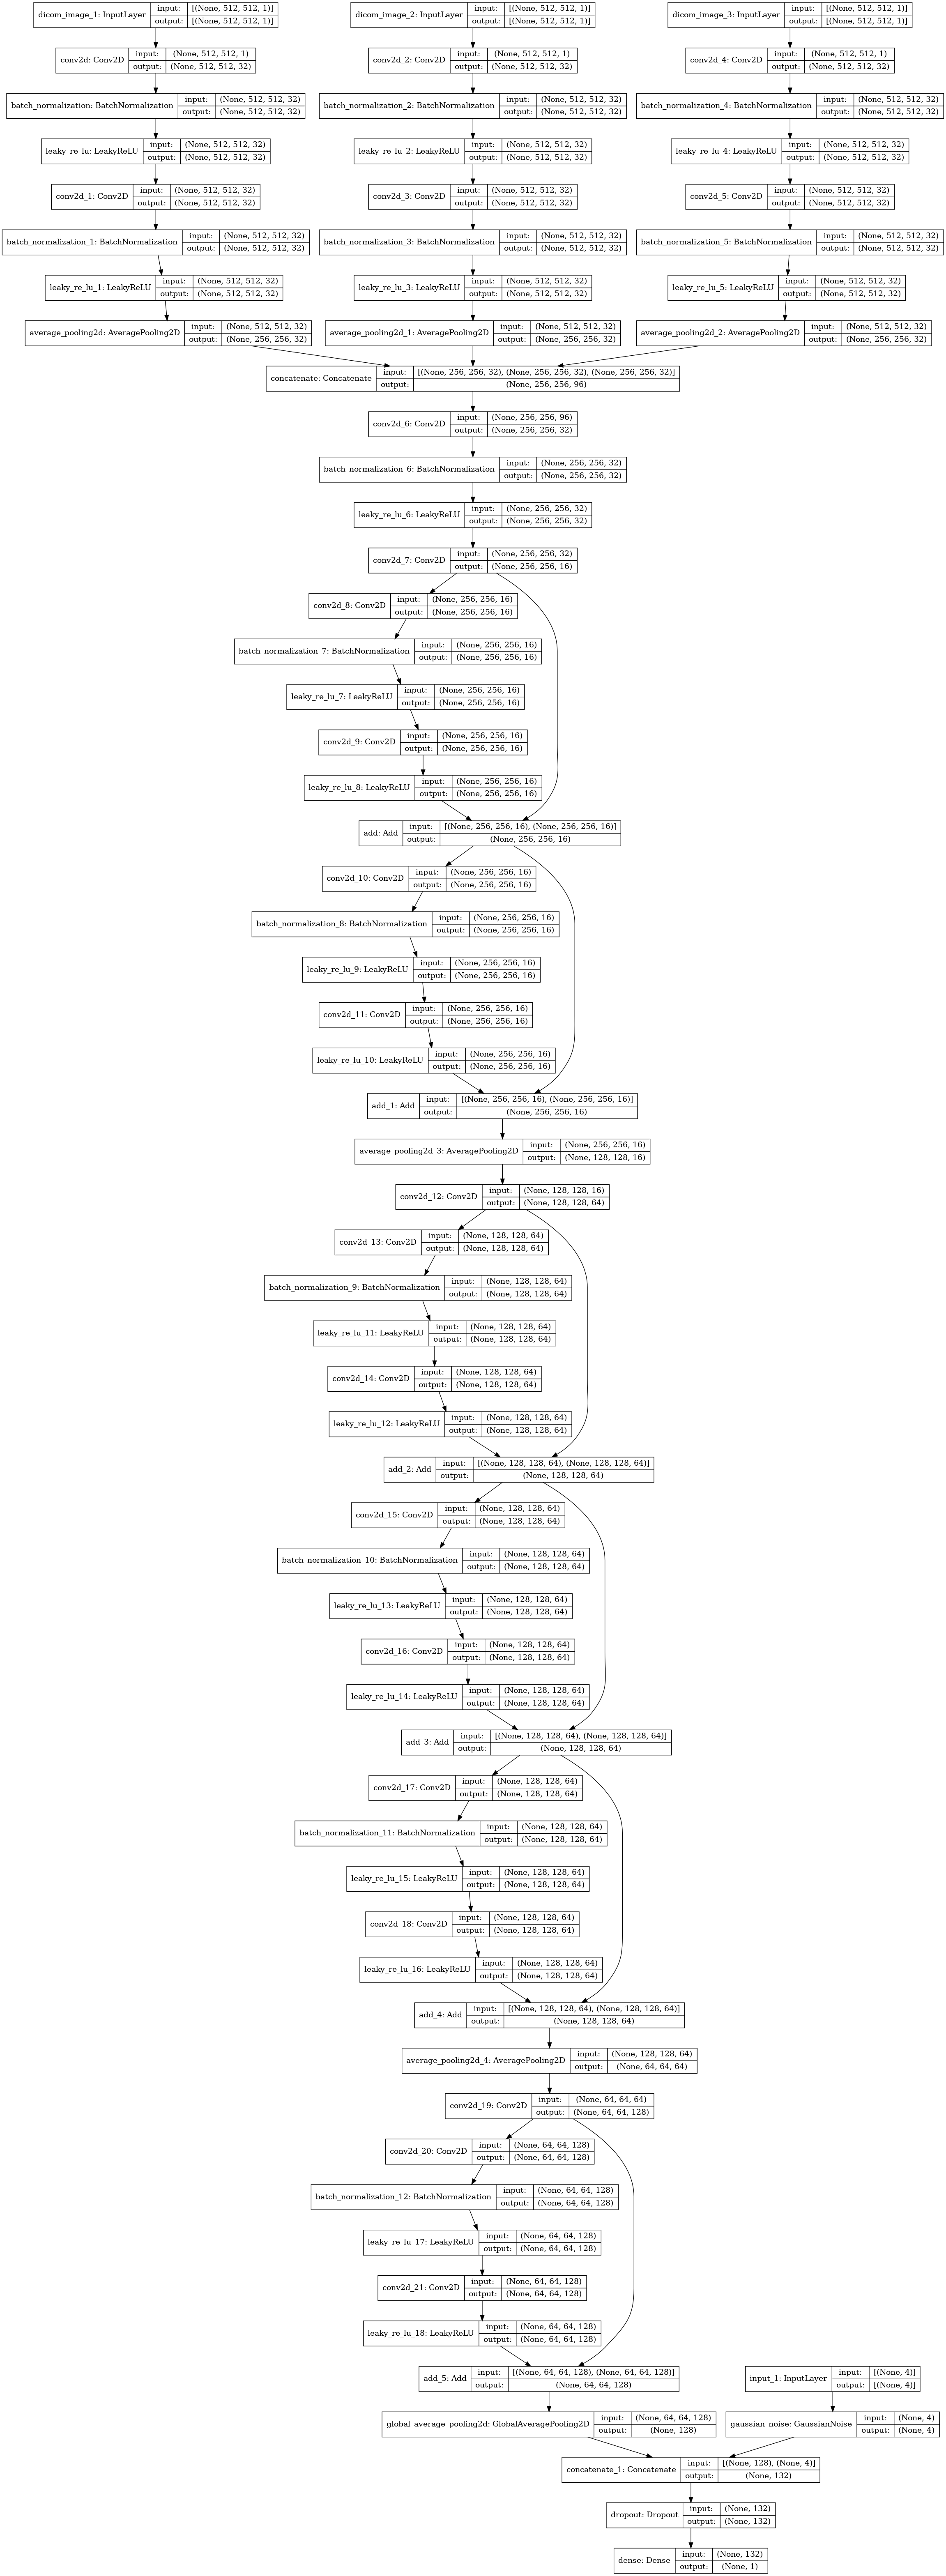

In [19]:
from tensorflow import keras
keras.utils.plot_model(model,'img.png', show_shapes=True)

In [20]:
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

model.fit_generator(IGenerator(keys=tr_p, 
                               a = A, 
                               tab = TAB, score = image_scores), 
                    steps_per_epoch = 200,
                    validation_data=IGenerator(keys=vl_p, 
                               a = A, 
                               tab = TAB, score = image_scores),
                    validation_steps = 100, 
                    callbacks = [er], 
                    epochs=30)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-04 20:23:05.932578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-08-04 20:23:09.815050: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 90/200 [============>.................] - ETA: 48s - loss: 0.6142 - mse: 211.6305 - mae: 9.7058 - mape: 1212.2303

2022-08-04 20:23:56.845359: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


200/200 [==============================] - 124s 566ms/step - loss: 0.5527 - mse: 137.9980 - mae: 7.9416 - mape: 905.7480 - val_loss: 0.4364 - val_mse: 27.9896 - val_mae: 3.9438 - val_mape: 313.5685
Epoch 2/30
200/200 [==============================] - 107s 534ms/step - loss: 0.4569 - mse: 93.6277 - mae: 6.8007 - mape: 794.9612 - val_loss: 0.3522 - val_mse: 29.0717 - val_mae: 3.9222 - val_mape: 176.8007
Epoch 3/30
200/200 [==============================] - 107s 532ms/step - loss: 0.4074 - mse: 57.9559 - mae: 5.5507 - mape: 437.0889 - val_loss: 0.4211 - val_mse: 32.9824 - val_mae: 4.1962 - val_mape: 198.6323
Epoch 4/30
200/200 [==============================] - 106s 529ms/step - loss: 0.4236 - mse: 54.2773 - mae: 5.3785 - mape: 531.3441 - val_loss: 0.7078 - val_mse: 78.6469 - val_mae: 5.0357 - val_mape: 296.4840
Epoch 5/30
200/200 [==============================] - 107s 533ms/step - loss: 0.4005 - mse: 50.4091 - mae: 5.2289 - mape: 392.6072 - val_loss: 0.2518 - val_mse: 28.8647 - val_mae

In [21]:
model.save('best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
#model = tf.keras.models.load_model('./best_model.h5')

In [23]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma,70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta,1000)
    sqrt = np.sqrt(2)
    metric = (delta/sigma_clip)*sqrt + np.log(sigma_clip*sqrt)
    return np.mean(metric)

In [24]:
from tqdm.notebook import tqdm
BAD_ID = ['ID00011637202177653955184']# 'ID00052637202186188008618','ID00104637202208063407045','ID00105637202208831864134','ID00168637202237852027833','ID00202637202249376026949','ID00267637202270790561585']

metric = []
for q in tqdm(range(1, 10)):
    m = []
    for p in vl_p:
        x, y,z  = [], [], []
        tab = [] 
        
        if p in BAD_ID:
            continue
            
        img_set = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
#         img_set = np.random.choice(img_set, size=50)
#         for i in img_set:
#             #i = np.random.choice(img_set, size=1)[0]
#             x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}'))
#             #i = np.random.choice(img_set, size=1)[0]
#             y.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}'))
#             tab.append(get_tab(train.loc[train.Patient == p, :])) 
#         tab = np.array(tab)

        for i in range(len(img_set)):                                   #Middle 50% being provided 
            img_set[i] = img_set[i][:-4]
    
        img_set = sorted(img_set, key=int)

        for i in range(len(img_set)):
            img_set[i] = img_set[i] + '.dcm'
            
        for i in range(int(0.25*len(img_set))):                        #Sometimes leads to errors as we could have folders with 400 slices
            img_set.pop()
            img_set.pop(0)
            
        if(len(img_set)>50):
            while(len(img_set)>50):
                img_set.pop()
                img_set.pop(0)
        
        for i in img_set:
            x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}'))
            y.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}'))
            z.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}'))
            tab.append(get_tab(train.loc[train.Patient == p, :])) 
        tab = np.array(tab)
    
        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        z = np.expand_dims(y, axis=-1)
        _a = model.predict([x,y,z, tab]) 
        a = np.quantile(_a, q / 10)
        
        percent_true = train.Percent.values[train.Patient == p]
        fvc_true = train.FVC.values[train.Patient == p]
        weeks_true = train.Weeks.values[train.Patient == p]
        
        fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
        percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
        m.append(score(fvc_true, fvc, percent))
    print(np.mean(m))
    metric.append(np.mean(m))

  0%|          | 0/9 [00:00<?, ?it/s]

6.582310921996446
6.582800023845838
6.583150169365895
6.5835549305300285
6.583949841825719
6.584360177330007
6.584638764474535
6.5854074251646075
6.586059102800224


In [25]:
q = (np.argmin(metric) + 1)/ 10

mean_LLL = np.mean(metric)
print(q)
print(mean_LLL)

0.1
6.584025706370367


In [26]:
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
sub.head() 

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [27]:
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [28]:
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 
for p in test.Patient.unique():
    x,y = [],[]
    tab = []
#     random_1 = np.random(20)
#     random_2 = np.random(20) 
#     if random_2 == random_1
#         random_2 = np.random(20)
    
    img_set = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
    img_set = np.random.choice(img_set, size=20)
    for i in img_set:
        #i = np.random.choice(img_set, size=1)[0]
        x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}'))
        #i = np.random.choice(img_set, size=1)[0]
        y.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}'))
        tab.append(get_tab(test.loc[test.Patient == p, :])) 
    tab = np.array(tab) 
            
    x = np.expand_dims(x, axis=-1) 
    y = np.expand_dims(y, axis=-1) 
    _a = model.predict([x,y, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:202 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model expects 4 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 512, 512, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 512, 512, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 4) dtype=float32>]


In [ ]:
for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 
    
    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
) 
sub.head()

In [ ]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [ ]:
sub.to_csv('submission.csv', index=False)


In [ ]:
sub.head(50)

def get_model(shape=(512, 512, 1)):
    def res_block(x, n_features):
        _x = x
        x = BatchNormalization()(x)
        x = LeakyReLU(0.05)(x)
    
        x = Conv2D(n_features, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = Add()([_x, x])
        return x
    
    input1 = Input(shape=shape, name= 'dicom_image_1')
    #input2 = Input(shape=shape, name= 'dicom_image_2')
    
    # 512
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(input1)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 256
    x = Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 8)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 128
    x = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 16)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 64
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 32)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 32
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 64)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)    
    
    # 16
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 128)
        
    # 16
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.6)(x) 
    x = Dense(1)(x)
    #x2 = Dense(1)(x)
    return Model([input1, inp2] , x)


# Defining model

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape, weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
        }
    return models_dict[model]

def build_model(shape=(512,512,1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x,x2])
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    model = Model([inp,inp2],x)
    return model

# Training

P = np.array(P)
subs = []
folds_history = []

er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

cpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'effnet_{EPOCHS}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only = SAVE_BEST,
    mode = 'auto'
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-8
)
model = build_model(model_class = MODEL_CLASS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mae')
history = model.fit_generator(IGenerator(keys=P,
                                        a= A,
                                        tab= TAB),
                             steps_per_epoch = 32,
                             validation_data = IGenerator(keys=P,
                                                         a = A,
                                                         tab = TAB),
                             validation_steps = 16,
                             callbacks = [cpt,rlp],
                             epochs = EPOCHS)
folds_history.append(history.history)
print('Trainig Done!')


<a href='./training_1'> Download File</a>